<a href="https://colab.research.google.com/github/nprime496/experiments/blob/main/Skip_Gram_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is inspired by [kdnugets](https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-skip-gram.html#:~:text=The%20Skip%2Dgram%20model%20architecture,jumps%20over%20the%20lazy%20dog%E2%80%9D.) using [Pytorch](https://pytorch.org/) framework.


We implement a skip-gram model to learn word embeddings from english [bible corpus](https://opus.nlpl.eu/bible-uedin.php).

## Imports

we will use Pytorch for model definition, torchtext for some text manipulation utils (tokenizer), numpy for diverse purposes and cleantext for text preparation.

In [47]:
from torch import nn
import torch
from torch import optim

In [48]:
import torchtext
from torchtext.data import get_tokenizer

In [49]:
!pip install cleantext

In [50]:
from cleantext import clean
import numpy as np

## Setup

We define the device we are working on : can be a CPU or a GPU ([cuda](https://fr.wikipedia.org/wiki/Compute_Unified_Device_Architecture))

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [52]:
!mkdir tmp #for storage

mkdir: cannot create directory ‘tmp’: File exists


## Load Dataset

The dataset we are using is bible corpus. The exact dataset used is available [here](https://drive.google.com/drive/folders/1Hj-0AyuTmOOLx9oNb8jI3X4N1usoiEE_?usp=sharing)

In [53]:
!gdown 1MirZihSiDbZ6rBmWCaof5OLcLPGp-rnc

Downloading...
From: https://drive.google.com/uc?id=1MirZihSiDbZ6rBmWCaof5OLcLPGp-rnc
To: /content/bible.txt
100% 4.45M/4.45M [00:00<00:00, 222MB/s]


In [54]:
with open("bible.txt") as f:
  sale=f.readlines()

In [55]:
sale[:5]

['1:1 In the beginning God created the heaven and the earth.\n',
 '\n',
 '1:2 And the earth was without form, and void; and darkness was upon\n',
 'the face of the deep. And the Spirit of God moved upon the face of the\n',
 'waters.\n']

## Data Preparation

We clean the dataset using some parameters.

* stopwords: Remove stop words
* param lowercase: Convert to lowercase
* numbers: Remove all digits
* punct: Remove all punctuations

In [56]:
%%time
from cleantext import clean
fichier=[]
for l in sale:
  cleaned=clean(l,stopwords=True,lowercase=True,numbers=True,punct=True)
  if len(cleaned.split(" "))>1:
    fichier.append(cleaned)

CPU times: user 27 s, sys: 2.6 s, total: 29.6 s
Wall time: 34.6 s


In [57]:
fichier[:5]

['beginning god created heaven earth',
 'earth without form void darkness upon',
 'face deep spirit god moved upon face',
 'god said let light light',
 'god saw light good god divided light']

We tokenize the dataset. 

Interesting: we talk about token instead of words because it may contain punctuations (but we removed them earlier)

In [58]:
tokenizer = get_tokenizer("basic_english")
tokens = tokenizer(" ".join(fichier))
tokens[:10]

['beginning',
 'god',
 'created',
 'heaven',
 'earth',
 'earth',
 'without',
 'form',
 'void',
 'darkness']

We create a dictionnary mapping each token to a unique id.

In [59]:
token2id={t.lower():i for i,t in enumerate(set(tokens))}
vocab_size=len(token2id)
vocab_size

12821

We create the reverse mapping for testing purposes.

In [60]:
reversetoken={token2id[v]:v for v in token2id.keys()}

We create `(target, context)` pairs such that each context consists of only one word. Hence our dataset from earlier gets transformed into pairs like (brown, quick), (brown, fox), (quick, the), (quick, brown) and so on. But how to supervise or train the model to know what is contextual and what is not?

We do this by using `((target, context), 1)` pairs as positive input samples where target is our word of interest and context is a context word occurring near the target word and the positive label 1 indicates this is a contextually relevant pair. We also feed in `((target, random), 0)` pairs as negative input samples where target is again our word of interest but random is just a randomly selected word from our vocabulary which has no context or association with our target word. Hence the negative label 0 indicates this is a contextually irrelevant pair.

e.g: "The quick brown fox."

```[((the,quick),1), (the,random,0),(((quick,brown),1),((quick,brown,1),...]```

 We do this so that the model can then learn which pairs of words are contextually relevant and which are not and generate similar embeddings for semantically similar words.

 It’s now time to build out our skip-gram generator which will give us pair of words and their relevance like we discussed earlier. 

In [61]:
import random

skips=None

def skipgram(corpus,vocab,tokenize=get_tokenizer("basic_english"),window_size=4):
  context=[]
  labels=[]
  negs=[]
  vocab_size=len(vocab)
  for sentence in corpus:
    words=tokenize(sentence)
    n=len(words)
    for i,w in enumerate(words):
      if not vocab.get(w):
        continue
      curr=vocab[w]
      for j in range(max(0,i-window_size),min(i+window_size+1,n)):
        #print("boucle")
        if i!=j:
          if not vocab.get(words[j]):
            continue
          context.append((vocab[w],vocab[words[j]],1))
          #labels.append(1)
          negs.append((vocab[w],random.randint(1,vocab_size-1),0))
  context.extend(negs)
  random.shuffle(context)
  return context[:]


Let's to a test.

In [62]:
c =skipgram(["whoever give a shit about what you are thinking is certainly stupid prat"],vocab=token2id,window_size=3)
for a,b,l in c:
  print(reversetoken[a],reversetoken[b],l)

certainly thinking 1
thinking party 0
thinking certainly 1
give whoever 1
certainly enmity 0
give toes 0
whoever caves 0
whoever give 1


In [63]:
%%time
skips= skipgram(fichier,vocab=token2id,window_size=3)

CPU times: user 6.34 s, sys: 98.8 ms, total: 6.44 s
Wall time: 6.43 s


In [64]:
print(f"We obtain {len(skips)} pairs")

We obtain 2808352 pairs


## Model Definition

We have a pair of input words for each training example consisting of one input target word having a unique numeric identifier and one context word having a unique numeric identifier. If it is a positive sample the word has contextual meaning, is a context wordand our label Y=1, else if it is a negative sample, the word has no contextual meaning, is just a random word and our label Y=0.

We will pass each of them to an embedding layer of their own, having size (vocab_size x embed_size) which will give us dense word embeddings for each of these two words (1 x embed_size for each word). Next up we use a merge layer to compute the dot product of these two embeddings and get the dot product value.

This is then sent to the dense sigmoid layer which outputs either a 1 or 0. We compare this with the actual label Y (1 or 0), compute the loss, backpropagate the errors to adjust the weights (in the embedding layer) and repeat this process for all (target, context) pairs for multiple epochs. The following figure tries to explain the same

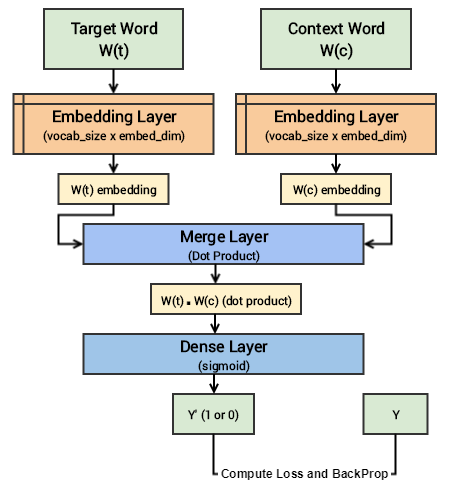

In [65]:
class SkipGramModel(nn.Module):
  def __init__(self,vocab_size,embedding_size):
    super(SkipGramModel,self).__init__()
    assert(vocab_size>0)
    self.vocab_size=vocab_size
    assert(embedding_size>0)
    self.embedding_size=embedding_size

    # define model
    self.emb_w=nn.Embedding(num_embeddings=self.vocab_size,embedding_dim=self.embedding_size)
    self.emb_c=nn.Embedding(num_embeddings=self.vocab_size,embedding_dim=self.embedding_size)
    self.linear=nn.Linear(self.embedding_size,1)
    self.sigmoid=nn.Sigmoid()

  def forward(self,X):
    (w,c)=X
    try:
      out1=self.emb_w(w)
      out2=self.emb_c(c)
      m=torch.mul(out1,out2)
      out=self.linear(m)
      out=self.sigmoid(out)
      return out
    except Exception as e:
      raise e




## Testing Model [TODO]


This is a bit unusual but necessary. Errors can slip in models very easily and we need to unit test them.

Here, I verify all layers weights change after a step, meaning backpropagation is working.

In [66]:
# check if any optimization has been done on each layer

def check_optimization_step(test_model):
  from copy import deepcopy
  old_model=deepcopy(test_model)
  result=test_model.forward(torch.LongTensor([[0,1,7],[7,1,0]]))
  
  criterion=nn.BCELoss()
  optimizer=optim.SGD(test_model.parameters(), lr=0.05, momentum=0.9)
  test_loss= criterion(result,torch.tensor([[0],[1],[0]],dtype=torch.float))
  test_loss.backward()
  optimizer.step()
  for layer1,layer2 in zip(test_model.named_parameters(),old_model.named_parameters()):
    assert(any((layer1[1]!=layer2[1]).ravel())),f"parameters on layer {layer1[0]} not optimized"

In [67]:
check_optimization_step(SkipGramModel(vocab_size,10))

## Training utils definition

In [68]:
def chunks(c,l, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(c[0]), n):
        yield (([e for e in c[0][i:i + n]],[e for e in c[1][i:i + n]]),l[i:i + n])

def chunks_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [69]:
def train(model,X_train,y_train,X_val=None,y_val=None,epochs=100,batch_size=40):
  assert((X_val is not None) == (y_val is not None)),"validation not properly set up"
  valid=(X_val is not None)
  from copy import deepcopy
  criterion=nn.BCELoss()
  best_model=None
  best_val_loss=np.inf
  optimizer=optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    n = len(X_train[0])//batch_size
    for x,y in chunks(X_train,y_train,n=batch_size):
      x = torch.tensor(x).to(device)
      y = torch.tensor(y,dtype=torch.float).to(device)
      optimizer.zero_grad()
      outputs=model(x)
      loss=criterion(outputs,y.unsqueeze(1))
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
    if valid:
      
      model.eval()#no grad calculation
      nval = len(X_val[0])//batch_size
      for xval,yval in chunks(X_val,y_val,n=batch_size):
        x = torch.tensor(xval).to(device)
        y = torch.tensor(yval,dtype=torch.float).to(device)
        outputs=model(x)
        loss=criterion(outputs,y.unsqueeze(1))
        val_loss+=loss.item()
    
    if(val_loss<best_val_loss):
      best_val_loss=val_loss
      best_model=deepcopy(model)
      torch.save(best_model.state_dict(),"tmp/best_model_so_far.dict")


    if epoch % 2==0:
      print(f'Epoch [{epoch + 1}] loss: {running_loss/n:.7f}',end="")
      if valid:
        print(f', val loss: {val_loss/nval:.7f}',end="")
      print()
  return best_val_loss,best_model


def score(X_test,y_test):
  pass

In [70]:
# torch.save(model.state_dict(), PATH)

# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

## Training

In [71]:
skips=skips[:1_000_000]

In [72]:
valid_set=100000

In [73]:
def create_dataset(skips):
  words=[e[0] for e in skips]
  context=[e[1] for e in skips]
  label=[e[2] for e in skips]
  return words,context,label

In [74]:
len(skips[valid_set:])

900000

In [75]:
%%time
words,context,label=create_dataset(skips[valid_set:])

CPU times: user 560 ms, sys: 4.92 ms, total: 565 ms
Wall time: 575 ms


In [76]:
%%time
words_valid,context_valid,label_valid=create_dataset(skips[:valid_set])

CPU times: user 50.4 ms, sys: 1.05 ms, total: 51.4 ms
Wall time: 51.9 ms


In [77]:
m=SkipGramModel(vocab_size,512)
m.to(device)

SkipGramModel(
  (emb_w): Embedding(12821, 512)
  (emb_c): Embedding(12821, 512)
  (linear): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [78]:
vocab_size

12821

In [79]:
max(token2id.values())

12820

In [ ]:
%%time
loss,best_model=train(m,(words,context),label,X_val=(words_valid,context_valid),y_val=label_valid,epochs=50)

Epoch [1] loss: 0.6993471, val loss: 0.6996545


## Predictions & Visualisation

In [ ]:
weights=best_model.emb_c.weight.detach().numpy()

In [ ]:
def is_context(model,word1,word2):
  a=token2id[word1]
  b=token2id[word2]
  return model.forward(torch.tensor([[a],[b]]))

In [ ]:
is_context(m,"lord","god")

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [reversetoken[idx] for idx in distance_matrix[token2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'egypt', 'noah', 'love', 'man','john']}

similar_words

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [token2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')